In [1]:
import pandas as pd
import numpy as np

In [9]:
def get_train_test_valid(root_dir,folder):
    '''Converts train test and valid lst files
    to dataframe
    args: root_dir: root directory
    folder: name of file in which the image filenames are
    '''
    
    train_dict = {}
    train_dict["image"] = []
    train_dict["latex_line"] = []
    with open(root_dir+folder) as f:
        arr = f.readlines()
    for record in arr:
        temp = record.split()
        train_dict["image"].append(temp[0])
        train_dict["latex_line"].append(temp[1])
    train_df = pd.DataFrame(train_dict)
    return train_df


In [12]:
root_dir = "data/"
train = "train.lst"
test = "test.lst"
valid = "valid.lst"
train_df = get_train_test_valid(root_dir,train)
val_df = get_train_test_valid(root_dir,test)
test_df = get_train_test_valid(root_dir,valid)
val_df.head()

,image,latex_line
0,7944775fc9.png,32771
1,78228211ca.png,32772
2,15b9034ba8.png,11
3,6968dfca15.png,14185
4,6cead0df53.png,98321


In [21]:
def add_latex(root_dir,latex_folder,df):
    '''Added latex expression to dataframe
    args: root_dir: Root directory
          latex_folder: Folder containing latex expressions
          df: train/test/valid dataframe in question
    returns: new dataframe with latex expressions added
    '''
    
    
    

    with open(root_dir+latex_folder) as f:
        arr = f.readlines()
    latex = []
    for index in df.latex_line.values:

        latex.append(arr[(int)(index)])
    df["latex_exp"] = latex
    return df

train_df = add_latex(root_dir,"formulas.norm.lst",train_df)
val_df = add_latex(root_dir,"formulas.norm.lst",val_df)
test_df = add_latex(root_dir,"formulas.norm.lst",test_df)



In [196]:

with open("data/latex_vocab.txt") as f:
    vocab = f.read().split("\n")
word2index = {"SOS":0,"EOS":1}
for i in range(len(vocab)):
    word2index[vocab[i]] = i+2
index2word = {0:"SOS",1:"EOS"}
for i in range(len(vocab)):
    index2word[i+2] = vocab[i]
    

In [22]:
train_df.head()

,image,latex_line,latex_exp
0,60ee748793.png,1,d s ^ { 2 } = ( 1 - { \frac { q c o s \theta }...
1,66667cee5b.png,2,\widetilde \gamma _ { \mathrm { h o p f } } \s...
2,1cbb05a562.png,3,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \..."
3,ed164cc822.png,4,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...
4,e265f9dc6b.png,5,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...


In [211]:
from torch.utils.data import DataLoader,Dataset,SequentialSampler
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2

class OCR_Dataset(Dataset):
    '''Custom dataset for latex images'''
    def __init__(self,csv,root_dir,transforms=None):
        self.csv = csv
        self.transforms = transforms
        self.root_dir = root_dir
    def __len__(self):
        return len(self.csv)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx.to_list()
        req = self.csv.iloc[idx]
        img_name = req.image
        latex = "SOS "+req.latex_exp+" EOS"
        
        encoding = [word2index[i] for i in latex.split()]
        path = self.root_dir+img_name
        img = cv2.imread(path)
        if self.transforms:
            img = self.transforms(img)
        sample = {"img":img,"label":latex,"encoding":torch.tensor(encoding)}
        return sample
        

In [212]:
ocr_dset = OCR_Dataset(train_df,root_dir = "data/images_processed/")

In [213]:
sample = ocr_dset[0]
print(sample)

{'img': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 25

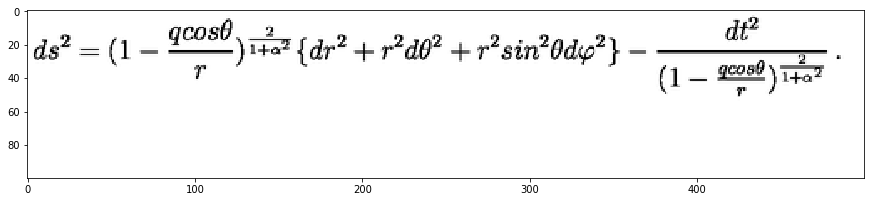

In [200]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,15))
plt.imshow(sample["img"])
plt.show()

In [75]:
class ConvNet(nn.Module):
    '''Definition of the convnet part of the paper'''
    def __init__(self):
        super(ConvNet,self).__init__()
        self.conv1 = nn.Sequential(
                    nn.Conv2d(3,512,kernel_size=3,stride=1),
                    nn.BatchNorm2d(512)
        )
        self.conv2 = nn.Sequential(
                    nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
                    nn.BatchNorm2d(512),
                    nn.MaxPool2d(kernel_size=(1,2),stride=(1,2))
        )
        self.conv3 = nn.Sequential(
                    nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1),
                    nn.MaxPool2d(kernel_size=(2,1),stride=(2,1))
        )
        self.conv4 = nn.Sequential(
                    nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
                    nn.BatchNorm2d(256)
        )
        self.conv5 = nn.Sequential(
                    nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
                    nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.final = nn.Sequential(
                nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
                nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        out = F.relu(self.final(x))
        return out


In [191]:
class rowEncoder(nn.Module):
    '''Definition of rowEncoder part of the network'''
    def __init__(self,inp_dim,hidden_dim):
        super(rowEncoder,self).__init__()
        self.inp_dim = inp_dim
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(self.inp_dim,self.hidden_dim,num_layers=1,batch_first=False,bidirectional=True)
    
    def forward(self,x,hidden):
    
        outputs,(hidden,cell) = self.lstm(x,hidden)

        return outputs,hidden
    
    def init_hidden(self, batch_size=1):
        return (torch.zeros(2, batch_size, self.hidden_dim),
                torch.zeros(2, batch_size, self.hidden_dim))
                
        
        

In [455]:
#### Decoder#####
class BahadanauDecoder(nn.Module):
    
    def __init__(self,hidden_size,output_size,n_layers=1):
        super(BahadanauDecoder,self).__init__()
        self.hidden_size=hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(self.output_size, self.hidden_size*2)
        self.fc_hidden = nn.Linear(self.hidden_size,self.hidden_size)
        self.fc_encoder = nn.Linear(self.hidden_size*2,self.hidden_size)
        self.weight = nn.Parameter(torch.FloatTensor(13,self.hidden_size))
        self.attn_combine = nn.Linear(self.hidden_size*2,self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size*4,self.hidden_size,batch_first=False)
        self.classifier = nn.Linear(self.hidden_size,self.output_size)
    
    
    def forward(self,inputs,hidden,encoder_outputs):
        encoder_outputs = encoder_outputs.squeeze()
        embedded = self.embedding(inputs).view(1, -1)
        print("enc ops",encoder_outputs.size())
        print("Hidden: ",hidden[0].size())
        #print(encoder_outputs.size())
        x = torch.tanh(self.fc_hidden(hidden[0].unsqueeze(0))+self.fc_encoder(encoder_outputs))
        print("X: ",x.size())
        x = x.permute(1,0,2)
        print("enc outputs mul: ",self.fc_encoder(encoder_outputs).size())
        print("Hidden Mul: ",self.fc_hidden(hidden[0]).size())
        print("weights: ",self.weight.size())
        
        scores = x.bmm(self.weight.unsqueeze(2))
        print(scores.size())
        attn_weights = F.softmax(scores,dim=1)
        
        context_vector = torch.bmm(attn_weights.permute(0,2,1),encoder_outputs.permute(1,0,2))
        
        print(embedded.size())
        print("CV: ",context_vector.size())
        print(embedded.long().repeat(13,1).size())
        output = torch.cat((embedded.long().repeat(13,1), context_vector.long().squeeze(1)), 1).unsqueeze(0)
        print(hidden[0].unsqueeze(0).size())
        hid = hidden[0].unsqueeze(0).unsqueeze(0)
        output, hidden = self.lstm(output,hid)
        
        output = F.log_softmax(self.classifier(output[0]), dim=1)
        return output, hidden, attn_weights
        

In [214]:
##Define dataloaders###
from torchvision import transforms
trans = transforms.Compose([transforms.ToPILImage(),transforms.Resize((100,240)),transforms.ToTensor()])
train_dataset = OCR_Dataset(train_df,root_dir = "data/images_processed/",transforms=trans)
train_sampler = SequentialSampler(train_dataset)
train_loader = DataLoader(train_dataset,batch_size=1,sampler=train_sampler)

In [240]:
### Define model and its optimizer ####
from torch.optim import Adam
torch.manual_seed(42)
conv = ConvNet()
enc = rowEncoder(64,128)
optim = Adam(conv.parameters(),lr=1e-5)

In [457]:
### Testing area ####
count = 0

for num,batch in enumerate(train_loader):
    img,label,encoding = batch["img"],batch["label"],batch["encoding"]
    output = conv(img)
    
    output = output.squeeze(0)
    output = output.permute(2,1,0)
    h = enc.init_hidden(batch_size=13)
    outputs,hidden = enc(output,h)
    print(hidden.size())
    
    dec_hidden = hidden
    
    for i in encoding[0]:
        print(i)
        a,b,c = dec(i,dec_hidden,outputs)
        
    break

torch.Size([2, 13, 128])
tensor(0)
enc ops torch.Size([30, 13, 256])
Hidden:  torch.Size([13, 128])
X:  torch.Size([30, 13, 128])
enc outputs mul:  torch.Size([30, 13, 128])
Hidden Mul:  torch.Size([13, 128])
weights:  torch.Size([13, 128])
torch.Size([13, 30, 1])
torch.Size([1, 256])
CV:  torch.Size([13, 1, 256])
torch.Size([13, 256])
torch.Size([1, 13, 128])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [183]:
word2index = {}
for i in range(len(vocab)):
    word2index[]

torch.Size([1, 13, 256])

In [222]:
max_len = 0
for exp in train_df.latex_exp:
    if len(exp.split())>max_len:
        max_len=len(exp.split())

In [456]:
dec = BahadanauDecoder(128,30)

In [353]:
arr.unsqueeze(2).shape

torch.Size([4, 4, 1])

In [356]:
arr.repeat(5,1,1).shape

torch.Size([5, 4, 4])